In [1]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from bc_power import utils
import pandas as pd
import pypsa
import numpy as np
import pyomo
import matplotlib.pyplot as plt
import math
pyomo.__version__

'6.5.0'

### Merging shapely polygons

In [ ]:
gdf = gpd.read_file("/mnt/c/Users/pmcw9/Delta-E/PICS/Data/regions/gadm41_CAN_1.json")
mask = gdf['NAME_1'] == "BritishColumbia"
west_lon = gdf[mask].geometry.bounds['minx'].iloc[0]
south_lat = gdf[mask].geometry.bounds['miny'].iloc[0]
east_lon = gdf[mask].geometry.bounds['maxx'].iloc[0]
north_lat = gdf[mask].geometry.bounds['maxy'].iloc[0]

In [ ]:
bbox = (west_lon, south_lat, east_lon, north_lat)
polygon_1 = shapely.geometry.box(*bbox, ccw=True)

bbox_2 = (west_lon-5, south_lat-5, east_lon-5, north_lat-5)
polygon_2 = shapely.geometry.box(*bbox_2, ccw=True)

polys = [polygon_1, polygon_2]

gpd.GeoSeries(polys).boundary.plot()

In [ ]:
west_lon,south_lat,east_lon ,north_lat

### Loading configuration file and testing extraction of year

In [ ]:
config_file = r"/mnt/c/Users/pmcw9/Delta-E/PICS/PyPSA_BC/config/config.yaml"
cfg = utils.load_config(config_file)

In [ ]:
start_year = cfg['cutout']["snapshots"]["start"][0][:4]
end_year = cfg['cutout']["snapshots"]["end"][0][:4]

In [ ]:
prefix = cfg['cutout']['path'] + cfg['cutout']['region']["name"]
suffix = "2021" + ".nc"

"_".join([prefix, suffix])

### Loading BC Hydro Load Data and Community Energy and Emissions Inventory

In [ ]:
bch = pd.read_csv("/mnt/c/Users/pmcw9/Delta-E/PICS/Data/BCH/BalancingAuthorityLoad2020.csv")
ceei_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/CEEI/bc_utilities_energy_and_emissions_data_at_the_community_level.xlsx"
ceei_bch = pd.read_excel(ceei_path,sheet_name="BC Hydro")
ceei_fbc_elec = pd.read_excel(ceei_path,sheet_name="FBC Elec") # Will not use data prior to 2013 otherwise need to pull Kelowna records too
ceei_nw = pd.read_excel(ceei_path,sheet_name="NewWest")
ceei_nel = pd.read_excel(ceei_path,sheet_name="NelsonHydro")
ceei_gf = pd.read_excel(ceei_path,sheet_name="GrandForks")
ceei_pen = pd.read_excel(ceei_path,sheet_name="Penticton")
ceei_sl = pd.read_excel(ceei_path,sheet_name="Summerland")
ceei_prc = pd.read_excel(ceei_path,sheet_name="Princeton")
ceei_yk = pd.read_excel(ceei_path,sheet_name="YukonElec")

In [ ]:
elc_col = "CONSUMPTION_TOTAL" # Units of KW-hr
ceei_list = [ceei_bch, ceei_fbc_elec, ceei_nw, ceei_nel, ceei_gf, ceei_pen, ceei_sl, ceei_prc, ceei_yk] # ceei_fbc_elec
year = 2020
tot = 0 # capture total electricity demand in MW-hr for all ELC demands in the dataset
for df in ceei_list:
    mask = (df['YEAR'] == year)  & ((df['ORG_TYPE'] != "Province") | (df["SOURCE"] != "BC Hydro"))
    tot += df[mask][elc_col].sum() / 1000 # convert to MW-hr

ratio = bch['Balancing Authority Load'].sum() / tot
print(f"The ratio between the BC Hydro load data and CEEI load is {ratio}")

In [ ]:
bch['Balancing Authority Load']

### Thermal PP

In [ ]:
tpp_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/SESIT/CODERS/data-pull/supply/generators.csv"
gen_gen_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/SESIT/CODERS/data-pull/supply/generation_generic.csv"
df = pd.read_csv(tpp_path)
gen_params = pd.read_csv(gen_gen_path)

In [ ]:
tpp_gen_types = {'NG_CT', 'NG_CG', 'NG_CC', 'Gas_CT', 'Oil_CT', "Coal", 'Oil_ST', 'Diesel_CT', 'Coal_CCS'}
# BC has only NG_CC, NG_CG, NG_CT
mask = (df["province"] == "BC") & (df["gen_type"].apply(lambda x: x in tpp_gen_types ))
tpp = df[mask].copy()

In [ ]:
gen_params[gen_params['generation_type'] == "NG_CT"].iloc[0]['efficiency']

In [ ]:
gen_params.columns

In [ ]:
tpp['gen_type']

### Testing conceptual cascade in PyPSA
    i) 3 reservoir cascade
    ii) testing spill and discharge

In [2]:
def get_multi_link_override():
    '''
    Gets the multi-link override. Needed for cascaded hydroelectric.
    '''
    # From PyPSA CHP Example: This ensures we can add 2 outputs for a single link i.e bus0 -> bus_1 AND bus_2
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        1.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    return override_component_attrs

def get_cascade_network(load_data, **kwargs):
    '''
    This function is going to replace function above. This function will feature a better design for adding links
    and other components when finished.
    '''
    # setup the network
    network = pypsa.Network(override_component_attrs=get_multi_link_override())
    network.set_snapshots(range(len(load_data)))
    
    network.add("Bus", "elc", carrier="AC")  # This likely will move
    network.add("Carrier", "water") # this may move since RoR also has water 
    network.add("Carrier", "inflow", co2_emissions=0.0) # likely will move
    network.add("Load", "elc demand", bus="elc", p_set=load_data) # likely will move
    
    for res,components in kwargs.items():
        for name,params in components.items():
            network.add(**params)

    return network

def create_reservoir_dict(df, inflow_data, cascade_name="demo"):
    '''
    Accepts a dataframe of reservoirs and their parameters and
    ordering of the the reservoirs. This can be used to create dictionaries
    which will be used to instantiate the model of the reservoir.
    
    Modifications: Likely need to have inflow in csv files which
                   can be imported later.
    '''
    res_dict = {}
    for idx,row in df.iterrows():
        aid = row['asset_id']
        max_inflow = max(inflow_data[aid])
        res_dict[aid] = {}
        

        # 1) add water_bus
        res_dict[aid]['water bus'] = {"class_name":"Bus",
                                          "name":" ".join([aid,"water bus"]),
                                          "carrier":"water",
                                        }

        # 2) add reservoir_bus
        res_dict[aid]['reservoir bus'] = {"class_name":"Bus",
                                          "name":" ".join([aid,"reservoir bus"]),
                                          "carrier":"water",
                                        }

        # 3) add store_link
        res_dict[aid]['store link'] = {"class_name":"Link",
                                       "name": " ".join([aid,"store link"]),
                                       "bus0": res_dict[aid]['water bus']['name'],
                                       "bus1": res_dict[aid]['reservoir bus']['name'],
                                       "efficiency":1., # mass balance
                                       "p_nom":1000000, # FIX: Should be derived to ensure larger than max(inflow + spill + discharge of any upstream reservoirs)
                                        } 
        
        # 4) get release_link
        res_dict[aid]['release link'] = {"class_name":"Link",
                                       "name": " ".join([aid,"release link"]),
                                       "bus0": res_dict[aid]['reservoir bus']['name'],
                                       "bus1": res_dict[aid]['water bus']['name'],
                                       "efficiency":1., # mass_balance
                                       "p_nom":row["s_capacity"] + row['p_capacity'],
                                        } 
        

        # 5) get reservoir store
        res_dict[aid]['reservoir store'] = {"class_name":"Store",
                                            "name":" ".join([aid,"reservoir store"]),
                                            "bus":res_dict[aid]['reservoir bus']['name'],
                                            "e_nom":row["r_capacity"]
                                            }
        
        # 6) add inflow generator
        res_dict[aid]['inflow generator'] = {"class_name":"Generator",
                                            "name": " ".join([aid,"inflow generator"]),
                                            "bus": res_dict[aid]['reservoir bus']['name'],
                                            "carrier": "inflow",
                                            "efficiency":1., # mass_balance
                                            "p_nom":max_inflow, # max(inflow series)
                                            "p_set":inflow_data[aid],
                                            "p_max_pu":[i / max_inflow if i != 0 else 0 for i in inflow_data[aid]],
                                            "p_min_pu":[i / max_inflow if i != 0 else 0 for i in inflow_data[aid]],
                                            } 

        # Terminal check
        if type(row["downstream"]) == str: # not terminal
            downstream_aid = " ".join([row["downstream"],"water bus"])
        else: # terminal
            downstream_aid = " ".join([cascade_name,"water exit"])
            # Add bus for the terminal reservoir
            res_dict[aid]['terminal bus'] = {"class_name":"Bus",
                                                "name":downstream_aid,
                                                "carrier":"water",
                                                }
            
            # Add spill store
            res_dict[aid]['terminal store'] = {"class_name":"Store",
                                                "name":cascade_name,
                                                "bus":downstream_aid,
                                                "e_nom":10000000 # The max storage needs to retain all possible water in the model horizon
                                                }

        # 7) get discharge link
        res_dict[aid]['discharge link'] = {"class_name":"Link",
                                            "name": " ".join([aid,"discharge link"]),
                                            "bus0": res_dict[aid]['water bus']['name'],
                                            "bus1": row['elc_bus'],
                                            "bus2": downstream_aid,
                                            "marginal_cost":0.0001,
                                            "efficiency":row['p_capacity'] / row['q_rated'], # power conversion 
                                            "efficiency2":1., # mass balance
                                            "p_nom":row['q_rated'], # Should be derived to ensure larger than max(inflow, spill + discharge)
                                            } 
        # 8) get spill link
        res_dict[aid]['spill_link'] = {"class_name":"Link",
                                        "name": " ".join([aid,"spill link"]),
                                        "bus0": res_dict[aid]['water bus']['name'],
                                        "bus1": downstream_aid,
                                        "efficiency":1., # mass_balance
                                        "p_nom":row['s_capacity'], # Should be derived to ensure larger than max(inflow, spill + discharge)
                                        } 

    return res_dict

In [3]:
res_data = [["r1",1,1,10,0,"r2",np.nan,"elc"],
        ["r2",1,1,10,0,"r3","r1","elc"],
        ["r3",1,1,10,0,np.nan,"r2","elc"]]

inflow_data = {"r1":[10,10,10],"r2":[0,0,0],"r3":[0,0,0]} # {"aid":[inflow_series], ...}

load_data = [1,1,1]

# connecting_node_code will need to be added later
# upstream doesn't matter other than to find the head reservoir
# downstream doesn't matter other than to find the terminal reservoir
reservoirs = pd.DataFrame(res_data, columns=["asset_id","q_rated","p_capacity","s_capacity","r_capacity","downstream","upstream","elc_bus"]) 
res_dict = create_reservoir_dict(reservoirs, inflow_data)
network = get_cascade_network(load_data,**res_dict)
reservoirs.head()

,asset_id,q_rated,p_capacity,s_capacity,r_capacity,downstream,upstream,elc_bus
0,r1,1,1,10,0,r2,NaN,elc
1,r2,1,1,10,0,r3,r1,elc
2,r3,1,1,10,0,NaN,r2,elc


INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.1s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 69 primals, 159 duals
Objective: 3.00e-04
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-_twgmu0t.lp --output /tmp/linopy-solve-oo246sza.sol
Reading problem data from '/tmp/linopy-problem-_twgmu0t.lp'...
159 rows, 69 columns, 257 non-zeros
991 lines were read
GLPK Simplex Optimizer 5.0
159 rows, 69 columns, 257 non-zeros
Preprocessing...
27 rows, 41 columns, 91 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27
*     0: obj =   3.000000000e-04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (130264 bytes)
Writing basic solution to '/tmp/linopy-solve-oo246sza.sol'...


/tmp/ipykernel_15419/4176836863.py:26: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_soc.get_shared_x_axes().join(ax_soc, ax_discharge,ax_inflow)


[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, '')]

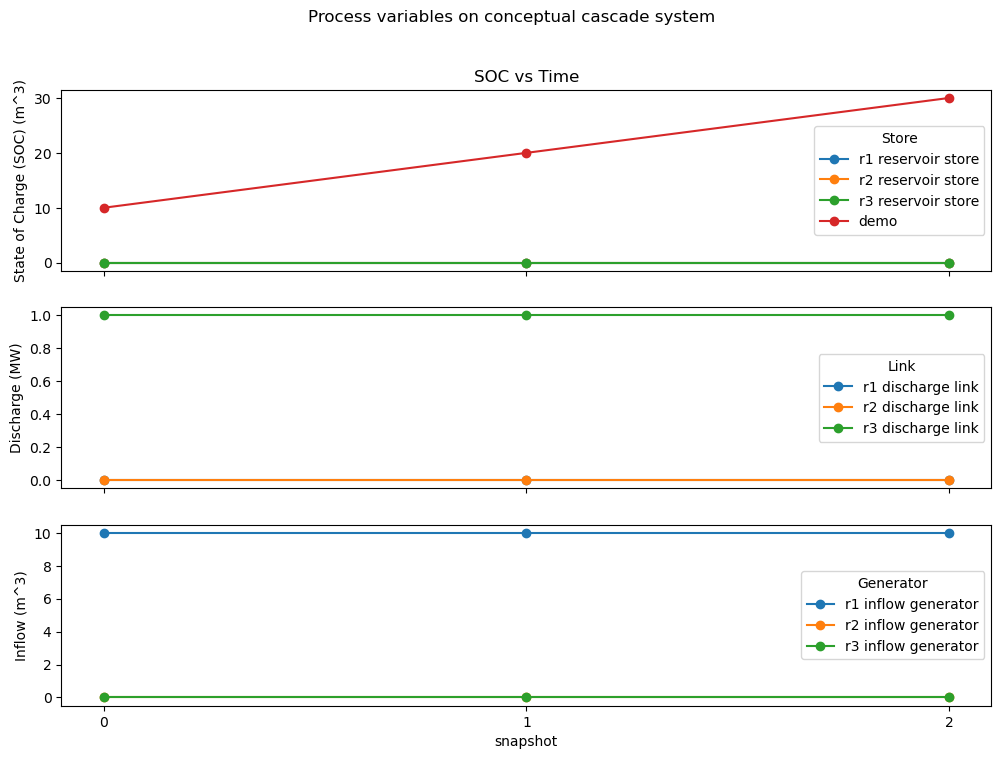

In [4]:
# network.lopf(pyomo=False, solver_logfile="tester.log");
network.optimize()

# create subplots
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,8))
fig.suptitle('Process variables on conceptual cascade system') 
# SOC
ax_soc = network.stores_t.e.plot(ax=axes[0],marker='o')
ax_soc.set_ylabel('State of Charge (SOC) (m^3)')
ax_soc.set_title('SOC vs Time')

# water discharges
col_sel = ["r1 discharge link", "r2 discharge link", "r3 discharge link"]
ax_discharge = network.links_t.p0[col_sel].plot(ax=axes[1],marker='o')
ax_discharge.set_ylabel('Discharge (MW)')

# inflow 
ax_inflow = network.generators_t.p.plot(ax=axes[2],marker='o')
ax_inflow.set_ylabel('Inflow (m^3)')

# Formatting
ax_inflow.set_xticks([0,1,2])
ax_soc.set_xticks([0,1,2])
ax_discharge.set_xticks([0,1,2])

ax_soc.get_shared_x_axes().join(ax_soc, ax_discharge,ax_inflow)
ax_soc.set_xlabel("")
ax_discharge.set_xlabel("")
ax_soc.set_xticklabels([])
ax_discharge.set_xticklabels([])
# ax_soc.sharex(ax_soc, ax_discharge,ax_inflow)

### Testing thermal PP in PyPSA
    i) Dispatch (check)
    ii) Emissions (check) (global)
    iii) Ramping (check)
    iv) UC (check)
    v) Gas-Grid vs no-Grid (check)
    vi) ramp_limit_start_up ()


In [5]:
def create_tpp_dict(df):
    '''
    Creates a thermal power plant dictionary that is used to add network components of the thermal powerplants.
    '''
    tpp_dict = {}
    for idx,row in df.iterrows():
        aid = row['name']
        tpp_dict[aid] = {}
        # tpp_dict[aid] = row.to_dict()
        # tpp_dict[aid]["class_name"] = "Generator"

        # create link + store representation of generator
        bus_name = " ".join([row['carrier'], "Bus"])
        tpp_dict[aid]= {"class_name":"Link",
                                    "name": " ".join([aid,"gen link"]),
                                    "bus0": bus_name,
                                    "bus1": row['bus'],
                                    "carrier": row['carrier'],
                                    "efficiency":row['efficiency'],
                                    "ramp_limit_up":row["ramp_limit_up"],
                                    "ramp_limit_down":row["ramp_limit_down"],
                                    "p_nom_extendable":False,
                                    "committable":row["committable"],
                                    "min_up_time":row["min_up_time"],
                                    "ramp_limit_start_up":row["ramp_limit_start_up"],
                                    "ramp_limit_shut_down":row["ramp_limit_shut_down"],
                                    "p_nom":row['p_nom'] / row['efficiency'],
                                    "marginal_cost":row['marginal_cost'], # cost per input unit (Need to be careful when combining fuel cost and variable cost 
                                    "p_min_pu":row['p_min_pu'] # watch out for the forced run condition
                                    }
        
    return tpp_dict

def create_tpp_network(load_data,emission_lim, **kwargs):
    '''
    Creates a thermal powerplant network.
    '''
    # setup the network
    network = pypsa.Network() #(override_component_attrs=get_uc_link_override())
    network.set_snapshots(range(len(load_data)))
    
    # Add carriers
    network.add("Carrier", "co2_emissions") # likely will move
    network.add("Carrier", "NG", co2_emissions=1.0) # likely will move (since defined based on infrastructure)

    # Add buses
    network.add("Bus", "elc", carrier="AC")  # This likely will move (since defined based on infrastructure)
    network.add("Bus", "NG Bus", carrier="NG")

    # Add loads
    network.add("Load", "elc demand", bus="elc", p_set=load_data) # likely will move
    
    # Add global constraints
    network.add("GlobalConstraint",
                name="co2 constraint",
                sense="<=",
                carrier_attribute="co2_emissions",
                constant=emission_lim)

    e_fill = 10000
    network.add(class_name="Store",
                name="NG store",
                bus="NG Bus",
                # e_nom_min=-float("inf"),
                # e_nom_max=0,
                e_nom=e_fill,
                e_initial=e_fill,
                # e_nom_extendable=True,
                # e_min_pu=1.0,
                # e_max_pu=0.0
    )
    
    # link store based
    for tpp,params in kwargs.items():
        network.add(**params)

    # generator based
    # for tpp,params in kwargs.items():
    #     network.add(**params)

    return network

In [6]:
# tpp_data = [['NG_CC', 'elc', 10, 'NG', 10, 0.4, False, 1, 1, 1, 0.2, 0.2],
#             ['NG_CT', 'elc', 10, 'NG', 10, 0.8, False, 1, 1, 1, 0.2, 0.2],
#             ['NG_CG', 'elc', 10, 'NG', 10, 0.7, False, 1, 1, 1, 0.2, 0.2]]
tpp_data = [['NG_CT', 'elc', 20, 'NG', 5, 1, False, 25, 1, 1, 0.5, 1, 1, 1, 0], 
            ['NG_CC', 'elc', 20, 'NG', 10, 1, False, 25, 1, 1, 1, 1, 1, 1, 0]] # Swap 0 -> 10
tpp = pd.DataFrame(tpp_data, columns=['name','bus','p_nom','carrier','marginal_cost','efficiency','committable','start_up_cost','min_up_time','min_down_time','ramp_limit_up','ramp_limit_down','ramp_limit_start_up','ramp_limit_shut_down', "p_min_pu"])
tpp.head()

,name,bus,p_nom,carrier,marginal_cost,efficiency,committable,start_up_cost,min_up_time,min_down_time,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_min_pu
0,NG_CT,elc,20,NG,5,1,False,25,1,1,0.5,1,1,1,0
1,NG_CC,elc,20,NG,10,1,False,25,1,1,1.0,1,1,1,0


In [7]:
load_data = [10, 25, 20] # [10, 15, 9, 15, 15]
emission_lim = 10000 # Model horizon

# ramp limit still has not been added

tpp_dict = create_tpp_dict(tpp)
network = create_tpp_network(load_data,emission_lim, **tpp_dict)
# m = network.optimize.create_model()
# m.solve(solver_name="glpk")

In [8]:
network.optimize()

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 12 primals, 36 duals
Objective: 3.00e+02
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-4ws4ei39.lp --output /tmp/linopy-solve-q0xt5bb8.sol
Reading problem data from '/tmp/linopy-problem-4ws4ei39.lp'...
36 rows, 12 columns, 58 non-zeros
240 lines were read
GLPK Simplex Optimizer 5.0
36 rows, 12 columns, 58 non-zeros
Preprocessing...
11 rows, 11 columns, 26 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 11
      0: obj =   5.500000000e+02 inf =   5.000e+00 (1)
      1: obj =   5.250000000e+02 inf =   0.000e+00 (0)
*     4: obj =   3.000000000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (50983 bytes)
Writing basic solution to '/tmp/linopy-solve-q0xt5bb8.sol'...


('ok', 'optimal')

In [9]:
network.links_t.mu_ramp_limit_up

Link-fix,NG_CT gen link,NG_CC gen link
snapshot,,
0,0.0,0.0
1,-5.0,0.0
2,0.0,0.0


### VRE concept in PyPSA
    i) Generation (check)
    ii) Snapshots (check)
    iii) investments (check)
    

In [26]:
def create_vre_network(vre_ts,load_ts,vre_dict):
    '''
    Adds a generator to a bus with a time varying load.
    '''
    # setup the network
    network = pypsa.Network()
    network.set_snapshots(load_ts.index)

    # Add buses
    network.add("Bus", "elc", carrier="AC")  # This likely will move (since defined based on infrastructure)
    network.add("Carrier", "NG")
    # Add loads
    network.add("Load", "elc demand", bus="elc", p_set=load_ts) # likely will move
    
    # Add base/peaking generator
    network.add(class_name="Generator",
                name="Filler",
                bus="elc",
                p_nom=10,
                carrier="NG",
                marginal_cost=10)

    for name,params in vre_dict.items():
        network.add(**params)

    return network


def create_vre_dict(vre,vre_ts_dict):
    '''
    Returns a vre_dict
    '''
    vre_dict = {}
    for idx,row in vre.iterrows():
        vre_dict[row["name"]] = {"class_name":row["class_name"],
                                 "name":row["name"],
                                 "bus":row["bus"],
                                 "p_nom":row["p_nom"],
                                 "marginal_cost":row["marginal_cost"],
                                 "p_nom_extendable":row["p_nom_extendable"],
                                 "capital_cost":row["capital_cost"],
                                 "p_max_pu":vre_ts_dict[row["name"]]}
        

    return vre_dict


In [50]:
# create snapshots
time = pd.date_range('2021-01-01 00:00:00', '2021-01-02 00:00:00', freq='1H', inclusive='left')

# calculation vre
t = np.linspace(0, 2*np.pi, len(time))
y = abs(np.sin(t)) 
load_ts = pd.Series([3]*len(time),index=time)
vre_ts = pd.Series(y, index=time)
vre_ts_dict = {}
vre_ts_dict["sol_generation"] = vre_ts

# create vre df
vre_data = [["Generator", "sol_generation", "elc", 0, 0.0001, True, 50]]
vre = pd.DataFrame(vre_data, columns=["class_name",'name','bus','p_nom',"marginal_cost","p_nom_extendable","capital_cost"])
vre.head()

,class_name,name,bus,p_nom,marginal_cost,p_nom_extendable,capital_cost
0,Generator,sol_generation,elc,0,0.0001,True,50


In [51]:
vre_dict = create_vre_dict(vre,vre_ts_dict)
network = create_vre_network(vre_ts, load_ts, vre_dict)

In [52]:
network.optimize()

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 49 primals, 121 duals
Objective: 4.05e+02
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-0ld3pd26.lp --output /tmp/linopy-solve-jr5z67c9.sol
Reading problem data from '/tmp/linopy-problem-0ld3pd26.lp'...
121 rows, 49 columns, 167 non-zeros
769 lines were read
GLPK Simplex Optimizer 5.0
121 rows, 49 columns, 167 non-zeros
Preprocessing...
22 rows, 23 columns, 44 non-zeros
Scaling...
 A: min|aij| =  1.362e-01  max|aij| =  1.000e+00  ratio =  7.344e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 22
*     0: obj =   7.200000000e+02 inf =   0.000e+00 (22)
*    31: obj =   4.047454477e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (90044 bytes)
Writing basic solution to '/tmp/linopy-solve-jr5z67c9.sol'...


('ok', 'optimal')

In [53]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Filler,elc,PQ,,10.0,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,10.00000
sol_generation,elc,PQ,,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4.10489


In [54]:
vre_ts * 7.5301

2021-01-01 00:00:00    0.000000e+00
2021-01-01 01:00:00    2.031597e+00
2021-01-01 02:00:00    3.912519e+00
2021-01-01 03:00:00    5.503268e+00
2021-01-01 04:00:00    6.685864e+00
2021-01-01 05:00:00    7.372601e+00
2021-01-01 06:00:00    7.512546e+00
2021-01-01 07:00:00    7.095319e+00
2021-01-01 08:00:00    6.151865e+00
2021-01-01 09:00:00    4.752155e+00
2021-01-01 10:00:00    3.000000e+00
2021-01-01 11:00:00    1.025348e+00
2021-01-01 12:00:00    1.025348e+00
2021-01-01 13:00:00    3.000000e+00
2021-01-01 14:00:00    4.752155e+00
2021-01-01 15:00:00    6.151865e+00
2021-01-01 16:00:00    7.095319e+00
2021-01-01 17:00:00    7.512546e+00
2021-01-01 18:00:00    7.372601e+00
2021-01-01 19:00:00    6.685864e+00
2021-01-01 20:00:00    5.503268e+00
2021-01-01 21:00:00    3.912519e+00
2021-01-01 22:00:00    2.031597e+00
2021-01-01 23:00:00    1.844343e-15
Freq: H, dtype: float64

In [55]:
network.generators_t.p

Generator,Filler,sol_generation
snapshot,,
2021-01-01 00:00:00,3.000000,0.00000
2021-01-01 01:00:00,1.892510,1.10749
2021-01-01 02:00:00,0.867166,2.13283
2021-01-01 03:00:00,0.000000,3.00000
2021-01-01 04:00:00,0.000000,3.00000
2021-01-01 05:00:00,0.000000,3.00000
2021-01-01 06:00:00,0.000000,3.00000
2021-01-01 07:00:00,0.000000,3.00000
2021-01-01 08:00:00,0.000000,3.00000


### Testing Linopy

In [46]:
n = pypsa.Network()

snapshots = range(4)

n.set_snapshots(snapshots)

n.madd("Bus", ["gas", "electricity"])

n.add("Generator", "gas", bus="gas", marginal_cost=10, p_nom=20000)

n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    committable=True,
    p_min_pu=0.1,
    efficiency=0.5,
    up_time_before=0,
    ramp_limit_start_up=0.01,
    min_up_time=3,
    start_up_cost=3333,
    p_nom=12000,
)

n.add(
    "Generator",
    "wind",
    bus="electricity",
    p_nom=800,
)

n.add("Load", "load", bus="electricity", p_set=[4000, 6000, 800, 5000])

n.optimize()

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.28s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 24 primals, 0 duals
Objective: 2.67e+05
Solver model: not available
Solver message: integer optimal



GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-v1ipkn5d.lp --output /tmp/linopy-solve-ne_5xyop.sol
Reading problem data from '/tmp/linopy-problem-v1ipkn5d.lp'...
43 rows, 24 columns, 81 non-zeros
12 integer variables, all of which are binary
305 lines were read
GLPK Integer Optimizer, v4.65
43 rows, 24 columns, 81 non-zeros
12 integer variables, all of which are binary
Preprocessing...
2 rows, 2 columns, 2 non-zeros
0 integer variables, none of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 2
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
2 rows, 2 columns, 2 non-zeros
*     0: obj =   2.673330000e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+     0: mip =     not found yet >=              -inf        (1; 0)


('ok', 'optimal')

In [47]:
n.links_t.p1

Link,OCGT
snapshot,
0,-3200.0
1,-5200.0
2,-600.0
3,-4200.0
